# Analysis of user sessions in Parallel Workload Logs

Reproducing Zakay and Feitelson 2013 (doi:10.1007/978-3-642-35867-8_12).

### Initializing libs and vars

In [1]:
import pandas as pd, numpy as np, json
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams["figure.figsize"] = [15, 5]

def print_general_stats(data):
    log_makespan = data['max_finish_time'].max() - data['first_submit_time'].min()
    log_length = data['last_submit_time'].max() - data['first_submit_time'].min()
    sess = data['nb_sessions']
    print(f"\
    Makespan:       {log_makespan / (24*3600):.2f} days\n\
    Length:         {log_length / (24*3600):.2f} days\n\
    #users:         {data['max_finish_time'].count()}\n\
    #sessions:      {data['nb_sessions'].sum()}\n\
    Sessions/user:  avg:{sess.mean():.0f} (min:{sess.min():.0f}, med:{sess.median():.0f}, max:{sess.max():.0f})\n\
    ")
    data.boxplot(column='nb_sessions', showmeans=True, widths=0.5, vert=False, figsize=(15,1))
    plt.xscale('log')
    plt.show()

def plot_length_stay(length_of_stay):
    agg = {}
    agg['0'] = ((length_of_stay == 0).sum())
    agg['<1d'] = (((length_of_stay > 0) & (length_of_stay < 24*3600)).sum())
    agg['<7d'] = (((length_of_stay >= 24*3600) & (length_of_stay < 7*24*3600)).sum())
    agg['<1m'] = (((length_of_stay >= 7*24*3600) & (length_of_stay < 30*24*3600)).sum())
    agg['<6m'] = (((length_of_stay >= 30*24*3600) & (length_of_stay < 6*30*24*3600)).sum())
    agg['6m+'] = (((length_of_stay >= 6*30*24*3600)).sum())

    fig, ax = plt.subplots()
    fig.set_size_inches(6,3)
    ax.bar(agg.keys(), agg.values(), width=.5)
    ax.set_xlabel("Length of stay")
    ax.set_ylabel("#users")
    plt.show()

def user_stats_to_session_data(user_stats):
    session_list = []
    for ses in user_stats['sessions']:
        session_list += ses
    sessions = pd.DataFrame(session_list)
    sessions['makespan'] = sessions['finish_time'] - sessions['first_submit_time']
    sessions['makespan_mn'] = sessions['makespan'] / 60
    sessions['length'] = sessions['last_submit_time'] - sessions['first_submit_time']
    sessions['length_mn'] = sessions['length'] / 60
    return sessions

def line_plot_distri_length(sessions, ax, label):
    distri_plot(sessions[sessions.length_mn > 2].length_mn, ax, label)

def distri_plot(serie, ax, label):
    # https://stackoverflow.com/a/8822554/13235501
    y,binEdges=np.histogram(serie,bins=np.linspace(0,100,num=100))
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax.plot(bincenters,y,'-',label=label)

def multi_plot_distri_length(data_array, label_array, ax):
    # Build session data for each dataset
    N = len(data_array)
    session_array = []
    for i in range(N):
        session_array.append(user_stats_to_session_data(data_array[i]))

    # Line graph, excluding sessions <= 2mn (like in Zackay&Feitelson2013)
    for i in range(N):
        line_plot_distri_length(session_array[i], ax[0], label_array[i])
    ax[0].set_xlim(1,100)
    ax[0].set_xscale('log')
    ax[0].set_xlabel("Session length (mn)")
    ax[0].set_ylabel("#sessions")
    ax[0].legend()

    # Boxplots
    session_length = pd.DataFrame()
    for i in range(N):
        sessions = session_array[i]
        session_length[label_array[i]] = sessions['length_mn']
    session_length.boxplot(showmeans=True, widths=0.5, vert=False, ax=ax[1])
    # Zoom in boxplot
    session_length.boxplot(showmeans=True, showfliers=False, widths=0.5, vert=False, ax=ax[2])

    # Distribution of #jobs/session
    session_nbjobs = pd.DataFrame()
    for i in range(N):
        bla = session_array[i]['nb_jobs'].value_counts(
            normalize=True).sort_index()
        bla.cumsum().plot.line(ax=ax[3], logx=True)
    ax[3].set_title("#jobs/session (cumulative)")

### Analyse the SWF log to get information about user sessions

For workload KTH:

In [10]:
input_swf = 'workloads/KTH-SP2-1996-2.1-cln.swf'

for threshold in [10, 20, 60]:
    out_dir = f'out/KTH_arrival_t{threshold}'
    ! ./swf2userSessions.py {input_swf} {out_dir} \
        --arrival {threshold} --session_stat --no_SABjson_output


SWF parsing done.
Number of users:     214
Number of sessions:  15247
The output files have been stored in the folder out/KTH_arrival_t10

SWF parsing done.
Number of users:     214
Number of sessions:  13050
The output files have been stored in the folder out/KTH_arrival_t20

SWF parsing done.
Number of users:     214
Number of sessions:  10293
The output files have been stored in the folder out/KTH_arrival_t60


For workload metacentrum:

In [11]:
input_swf = 'workloads/metacentrum.swf'

for threshold in [10, 20, 60]:
    out_dir = f'out/mc_arrival_t{threshold}'
    ! ./swf2userSessions.py {input_swf} {out_dir} \
        --arrival {threshold} --session_stat --no_SABjson_output

Processing swf line 100000
Processing swf line 200000
Processing swf line 300000
Processing swf line 400000
Processing swf line 500000
Processing swf line 600000
Processing swf line 700000
Processing swf line 800000
Processing swf line 900000
Processing swf line 1000000
Processing swf line 1100000
Processing swf line 1200000
Processing swf line 1300000
Processing swf line 1400000
Processing swf line 1500000
Processing swf line 1600000
Processing swf line 1700000
Processing swf line 1800000
Processing swf line 1900000
Processing swf line 2000000
Processing swf line 2100000
Processing swf line 2200000
Processing swf line 2300000
Processing swf line 2400000
Processing swf line 2500000
Processing swf line 2600000
Processing swf line 2700000
Processing swf line 2800000
Processing swf line 2900000
Processing swf line 3000000
Processing swf line 3100000
Processing swf line 3200000
Processing swf line 3300000
Processing swf line 3400000
Processing swf line 3500000
Processing swf line 3600000
P

Raw visualization of output json:

In [13]:
data_file = 'out/KTH_arrival_t60_session_stat.json'
data = pd.read_json(data_file, orient='index')
data


first_submit_time  max_finish_time  last_submit_time  last_finish_time  \
12              599850         29017402          29016615          29017402   
13              600022         19801346          19706570          19801346   
14              600476         27859303          27669361          27859303   
15              600836         20332528          20325683          20326477   
16              603930          4421620           4420473           4421620   
..                 ...              ...               ...               ...   
210           29117445         29303265          29302518          29303224   
211           29122750         29123244          29122750          29123244   
212           29206099         29299029          29297134          29299029   
213           29294165         29302118          29294165          29302118   
214           29299986         29301206          29299986          29301206   

     nb_sessions                                           sessions  
12           176  [{'first_submit_time': 599850.0, 'last_submit_...  
13           225  [{'first_submit_time': 600022.0, 'last_submit_...  
14           204  [{'first_submit_time': 600476.0, 'last_submit_...  
15           138  [{'first_submit_time': 600836.0, 'last_submit_...  
16            39  [{'first_submit_time': 603930.0, 'last_submit_...  
..           ...                                                ...  
210            2  [{'first_submit_time': 29117445.0, 'last_submi...  
211            1  [{'first_submit_time': 29122750.0, 'last_submi...  
212            3  [{'first_submit_time': 29206099.0, 'last_submi...  
213            1  [{'first_submit_time': 29294165.0, 'last_submi...  
214            1  [{'first_submit_time': 29299986.0, 'last_submi...  

[214 rows x 6 columns]

### Workload KTH

Charge dataframe in memory and print global stats.

KTH_arrival_t10:
    Makespan:       332.93 days
    Length:         332.91 days
    #users:         214
    #sessions:      15247
    Sessions/user:  avg:71 (min:1, med:21, max:745)
    


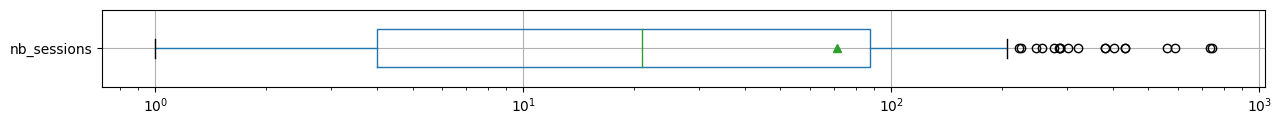

KTH_arrival_t20:
    Makespan:       332.93 days
    Length:         332.91 days
    #users:         214
    #sessions:      13050
    Sessions/user:  avg:61 (min:1, med:16, max:647)
    


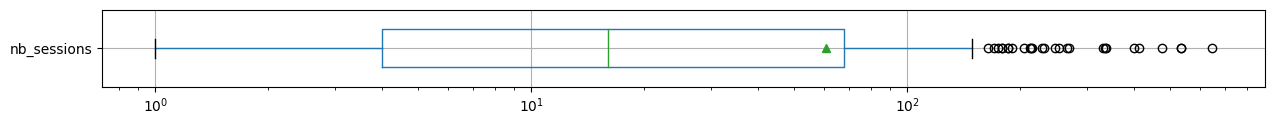

KTH_arrival_t60:
    Makespan:       332.93 days
    Length:         332.91 days
    #users:         214
    #sessions:      10293
    Sessions/user:  avg:48 (min:1, med:12, max:514)
    


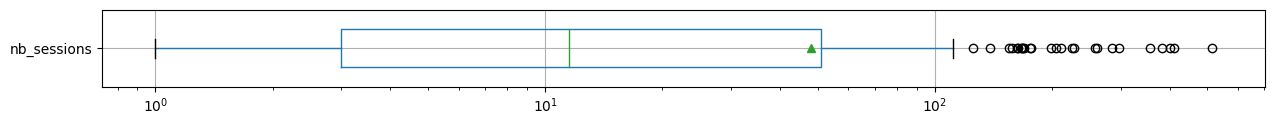

In [14]:
KTH_a_t10 = pd.read_json('out/KTH_arrival_t10_session_stat.json', orient='index')
KTH_a_t20 = pd.read_json('out/KTH_arrival_t20_session_stat.json', orient='index')
KTH_a_t60 = pd.read_json('out/KTH_arrival_t60_session_stat.json', orient='index')

print("KTH_arrival_t10:")
print_general_stats(KTH_a_t10)
print("KTH_arrival_t20:")
print_general_stats(KTH_a_t20)
print("KTH_arrival_t60:")
print_general_stats(KTH_a_t60)

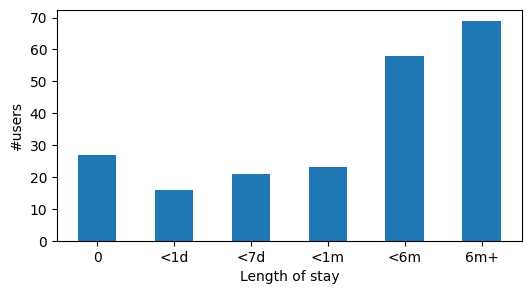

In [15]:
length_of_stay = KTH_a_t10['last_submit_time'] - KTH_a_t10['first_submit_time']
plot_length_stay(length_of_stay)

Text(0.5, 1.0, 'Distribution of session lengths (log: KTH, delimitation: Arrival)')

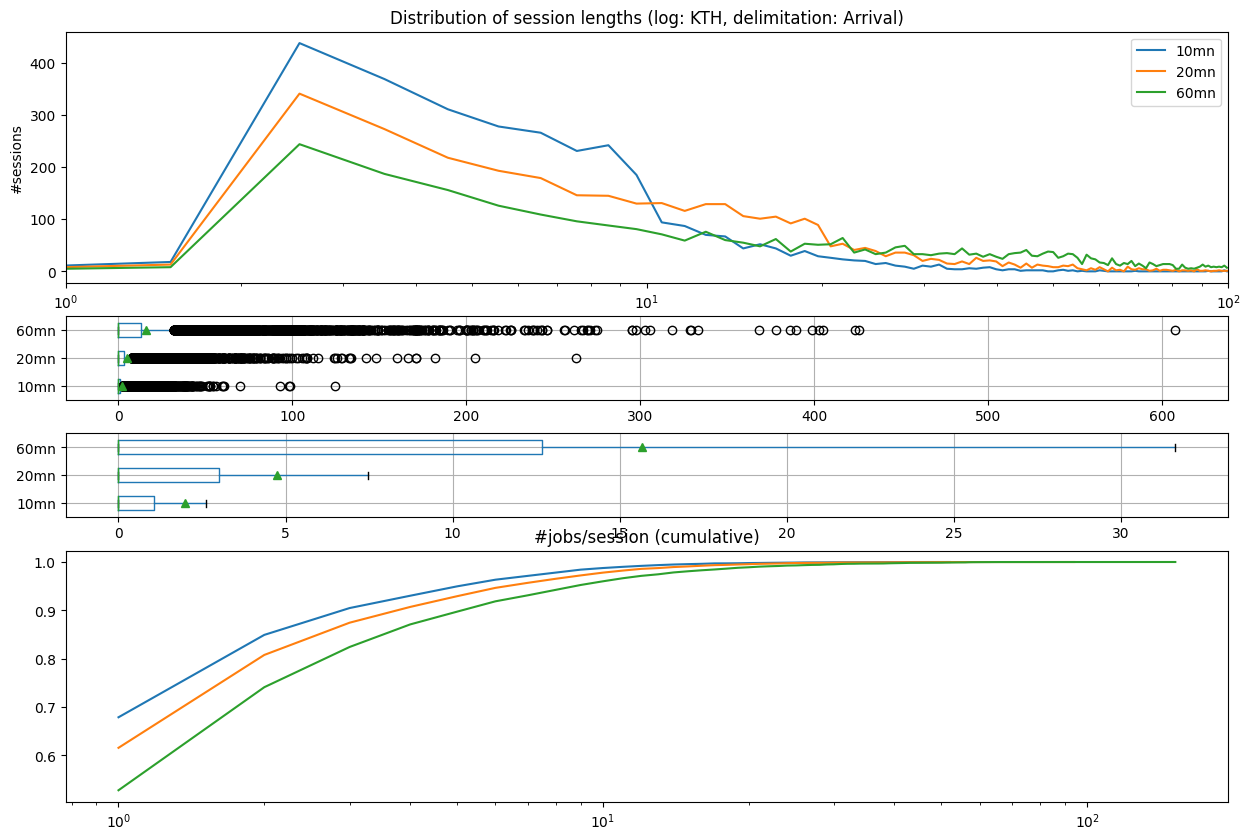

In [16]:
fig, ax = plt.subplots(4, gridspec_kw={'height_ratios': [3,1,1,3]}, figsize=[15,10])
multi_plot_distri_length(
    [KTH_a_t10, KTH_a_t20, KTH_a_t60],
    ["10mn", "20mn", "60mn"],
    ax
)
ax[0].set_title("Distribution of session lengths (log: KTH, delimitation: Arrival)")

### Workload Metacentrum

Charge dataframe in memory and print global stats.

mc_arrival_t10:
    Makespan:       836.52 days
    Length:         729.00 days
    #users:         878
    #sessions:      206655
    Sessions/user:  avg:235 (min:1, med:39, max:18015)
    


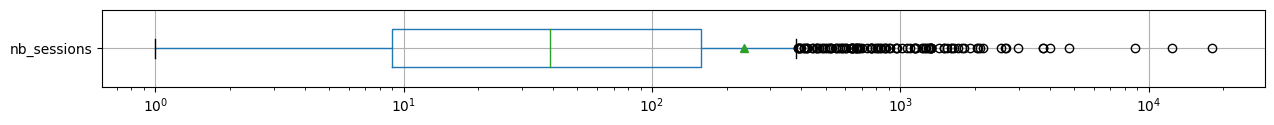

mc_arrival_t20:
    Makespan:       836.52 days
    Length:         729.00 days
    #users:         878
    #sessions:      152612
    Sessions/user:  avg:174 (min:1, med:33, max:10918)
    


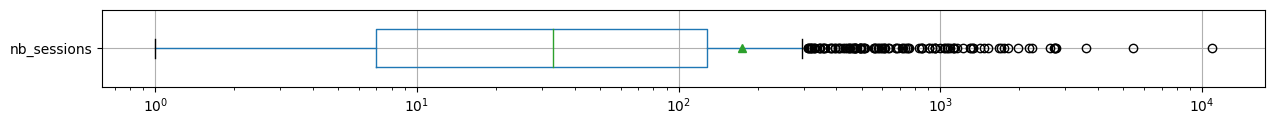

mc_arrival_t60:
    Makespan:       836.52 days
    Length:         729.00 days
    #users:         878
    #sessions:      100655
    Sessions/user:  avg:115 (min:1, med:25, max:2896)
    


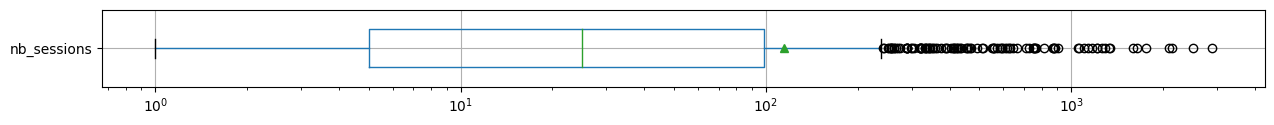

In [17]:
mc_a_t10 = pd.read_json('out/mc_arrival_t10_session_stat.json', orient='index')
mc_a_t20 = pd.read_json('out/mc_arrival_t20_session_stat.json', orient='index')
mc_a_t60 = pd.read_json('out/mc_arrival_t60_session_stat.json', orient='index')

print("mc_arrival_t10:")
print_general_stats(mc_a_t10)
print("mc_arrival_t20:")
print_general_stats(mc_a_t20)
print("mc_arrival_t60:")
print_general_stats(mc_a_t60)

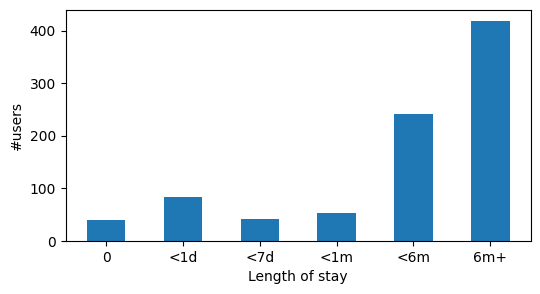

In [18]:
length_of_stay = mc_a_t10['last_submit_time'] - mc_a_t10['first_submit_time']
agg = {}
agg['0'] = ((length_of_stay == 0).sum())
agg['<1d'] = (((length_of_stay > 0) & (length_of_stay < 24*3600)).sum())
agg['<7d'] = (((length_of_stay >= 24*3600) & (length_of_stay < 7*24*3600)).sum())
agg['<1m'] = (((length_of_stay >= 7*24*3600) & (length_of_stay < 30*24*3600)).sum())
agg['<6m'] = (((length_of_stay >= 30*24*3600) & (length_of_stay < 6*30*24*3600)).sum())
agg['6m+'] = (((length_of_stay >= 6*30*24*3600)).sum())

fig, ax = plt.subplots()
fig.set_size_inches(6,3)
ax.bar(agg.keys(), agg.values(), width=.5)
ax.set_xlabel("Length of stay")
ax.set_ylabel("#users")
plt.show()

Text(0.5, 1.0, 'Distribution of session lengths (log: Metacentrum, delimitation: Arrival)')

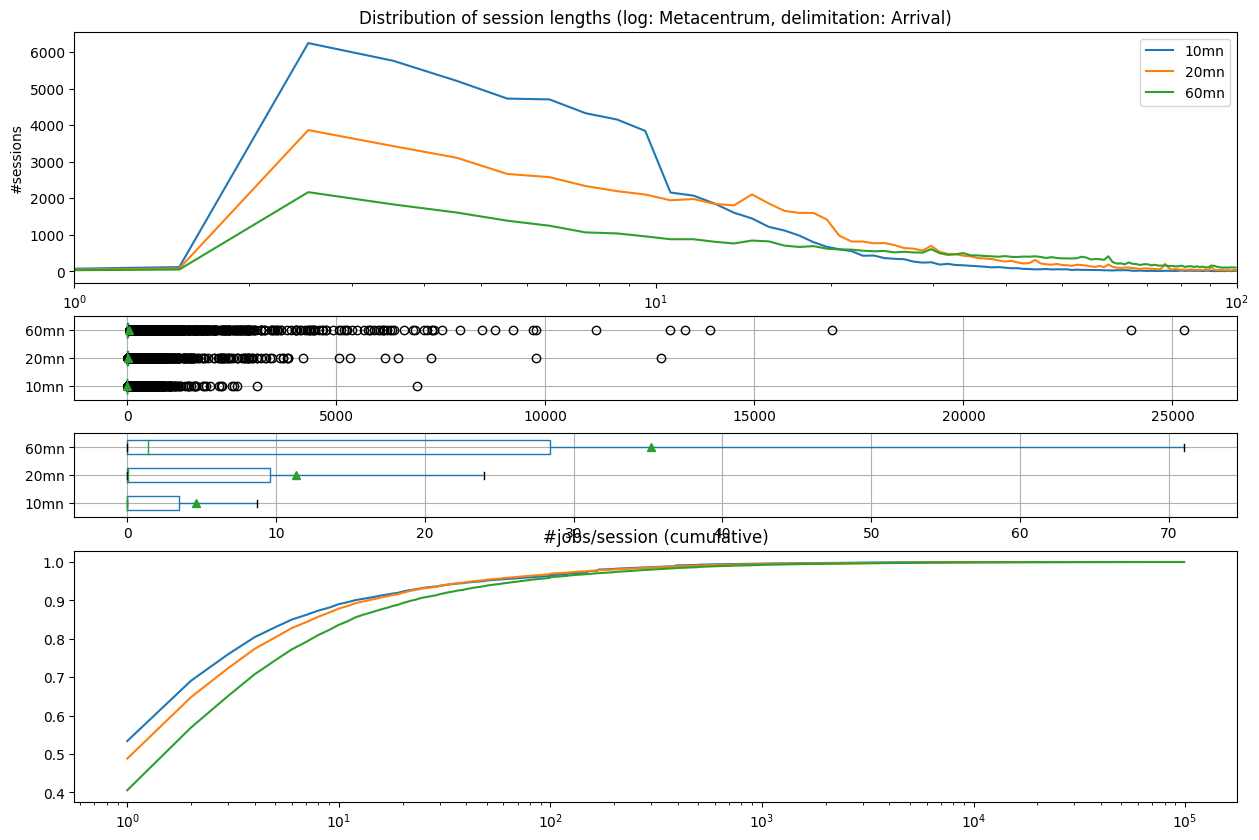

In [19]:
fig, ax = plt.subplots(4, gridspec_kw={'height_ratios': [3,1,1,3]}, figsize=[15,10])
multi_plot_distri_length(
    [mc_a_t10, mc_a_t20, mc_a_t60],
    ["10mn", "20mn", "60mn"],
    ax
)
ax[0].set_title("Distribution of session lengths (log: Metacentrum, delimitation: Arrival)")

### Workload Metacentrum_EuroPar

The workload used in the article Madon et al. 2022.

Do the session analysis:

In [20]:
input_swf = 'workloads/MC_EuroPar.swf'

for threshold in [10, 20, 60]:
    out_dir = f'out/mc_europar_a{threshold}'
    ! ./swf2userSessions.py {input_swf} {out_dir} \
        --arrival {threshold} --session_stat --no_SABjson_output

Processing swf line 1600000
SWF parsing done.
Number of users:     546
Number of sessions:  44799
The output files have been stored in the folder out/mc_europar_a10
Processing swf line 1600000
SWF parsing done.
Number of users:     546
Number of sessions:  34701
The output files have been stored in the folder out/mc_europar_a20
Processing swf line 1600000
SWF parsing done.
Number of users:     546
Number of sessions:  23638
The output files have been stored in the folder out/mc_europar_a60


MC_EuroPar_arrival_t10:
    Makespan:       237.00 days
    Length:         183.04 days
    #users:         546
    #sessions:      44799
    Sessions/user:  avg:82 (min:1, med:18, max:2837)
    


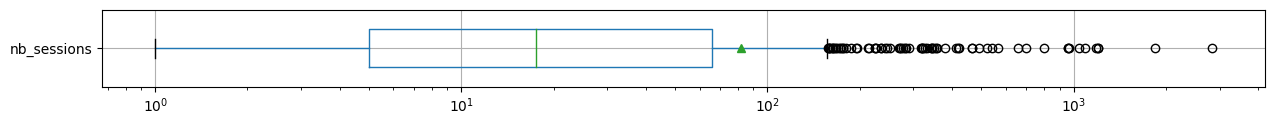

MC_EuroPar_arrival_t20:
    Makespan:       237.00 days
    Length:         183.04 days
    #users:         546
    #sessions:      34701
    Sessions/user:  avg:64 (min:1, med:15, max:1922)
    


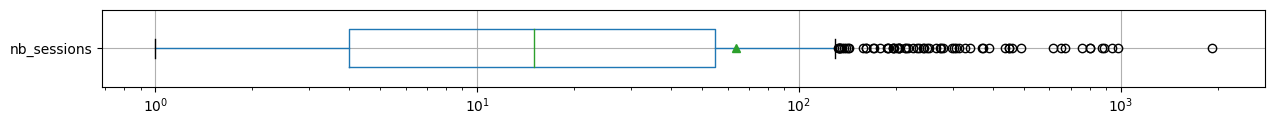

MC_EuroPar_arrival_t60:
    Makespan:       237.00 days
    Length:         183.04 days
    #users:         546
    #sessions:      23638
    Sessions/user:  avg:43 (min:1, med:12, max:763)
    


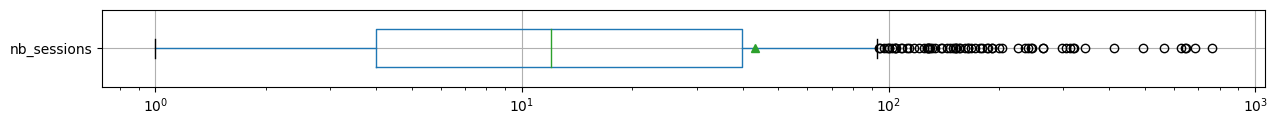

In [21]:
mc_a_t10 = pd.read_json('out/mc_europar_a10_session_stat.json', orient='index', convert_dates=False)
mc_a_t20 = pd.read_json('out/mc_europar_a20_session_stat.json', orient='index', convert_dates=False)
mc_a_t60 = pd.read_json('out/mc_europar_a60_session_stat.json', orient='index', convert_dates=False)

print("MC_EuroPar_arrival_t10:")
print_general_stats(mc_a_t10)
print("MC_EuroPar_arrival_t20:")
print_general_stats(mc_a_t20)
print("MC_EuroPar_arrival_t60:")
print_general_stats(mc_a_t60)

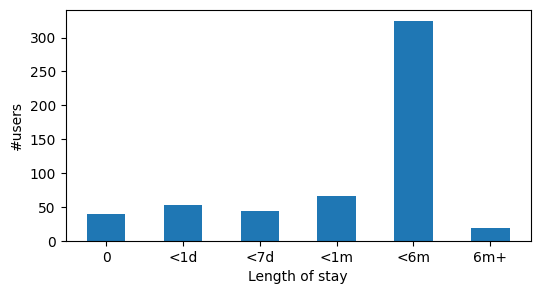

In [22]:
length_of_stay = mc_a_t10['last_submit_time'] - mc_a_t10['first_submit_time']
agg = {}
agg['0'] = ((length_of_stay == 0).sum())
agg['<1d'] = (((length_of_stay > 0) & (length_of_stay < 24*3600)).sum())
agg['<7d'] = (((length_of_stay >= 24*3600) & (length_of_stay < 7*24*3600)).sum())
agg['<1m'] = (((length_of_stay >= 7*24*3600) & (length_of_stay < 30*24*3600)).sum())
agg['<6m'] = (((length_of_stay >= 30*24*3600) & (length_of_stay < 6*30*24*3600)).sum())
agg['6m+'] = (((length_of_stay >= 6*30*24*3600)).sum())

fig, ax = plt.subplots()
fig.set_size_inches(6,3)
ax.bar(agg.keys(), agg.values(), width=.5)
ax.set_xlabel("Length of stay")
ax.set_ylabel("#users")
plt.show()


Text(0.5, 1.0, 'Distribution of session lengths (log: Metacentrum, delimitation: Arrival)')

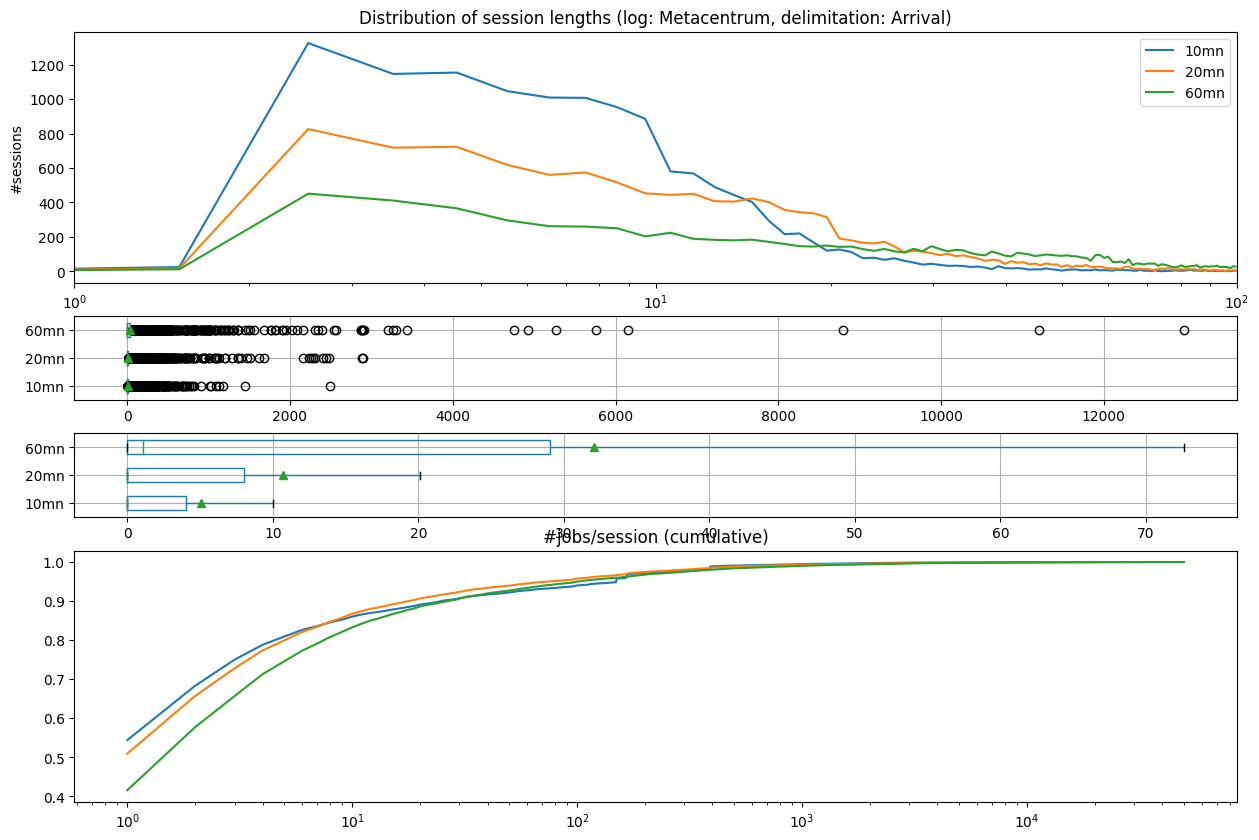

In [25]:
fig, ax = plt.subplots(4, gridspec_kw={'height_ratios': [3,1,1,3]}, figsize=[15,10])
multi_plot_distri_length(
    [mc_a_t10, mc_a_t20, mc_a_t60],
    ["10mn", "20mn", "60mn"],
    ax
)
ax[0].set_title("Distribution of session lengths (log: Metacentrum, delimitation: Arrival)")